In [216]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from pathlib import Path

## Audio MNIST Dataset

This dataset consists of numbers spoken.

> Goal:
> build a conv net to find the digit to the audio

## Example

Let's look at an example

In [197]:
waveform, sample_rate = torchaudio.load('/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings/0_yweweler_39.wav')

# Print information about the loaded audio
print(f"Shape of waveform: {waveform.shape}")
print(f"Sample rate: {sample_rate}")
print(f"Duration: {waveform.shape[1] / sample_rate:.2f} seconds")

Shape of waveform: torch.Size([1, 3540])
Sample rate: 8000
Duration: 0.44 seconds


In [198]:
def plot_audio(waveform):
    # 1. Plot the waveform (amplitude over time)
    plt.figure(figsize=(10, 4))
    time_axis = torch.arange(0, waveform.shape[1]) / sample_rate
    plt.plot(time_axis, waveform[0], color='blue')  # Plot first channel for stereo files
    plt.title('Waveform')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.savefig('waveform_plot.png')
    plt.show()
    
    # 2. Create a spectrogram (frequency content over time)
    spectrogram_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            win_length=1024,
            hop_length=512,
            n_mels=256
    )
    spec = spectrogram_transform(waveform)
    
    # Convert to decibels for better visualization
    spec_db = torchaudio.transforms.AmplitudeToDB()(spec)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(spec_db[0], aspect='auto', origin='lower', 
               extent=[0, waveform.shape[1]/sample_rate, 0, sample_rate/2])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.savefig('spectrogram.png')
    plt.show()

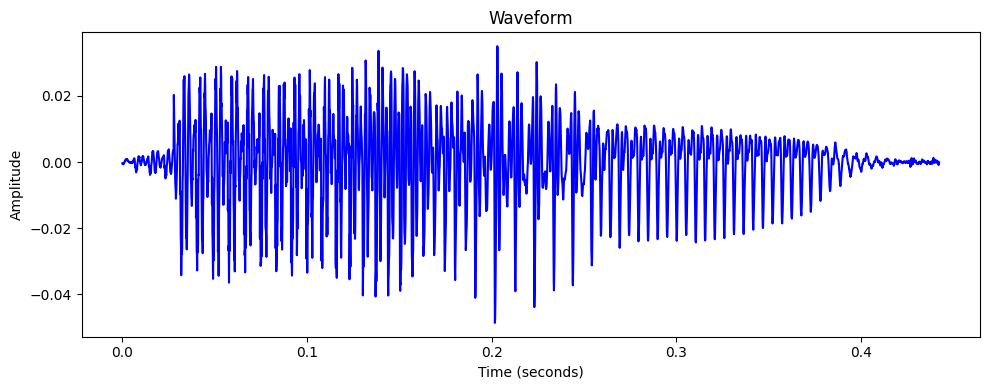

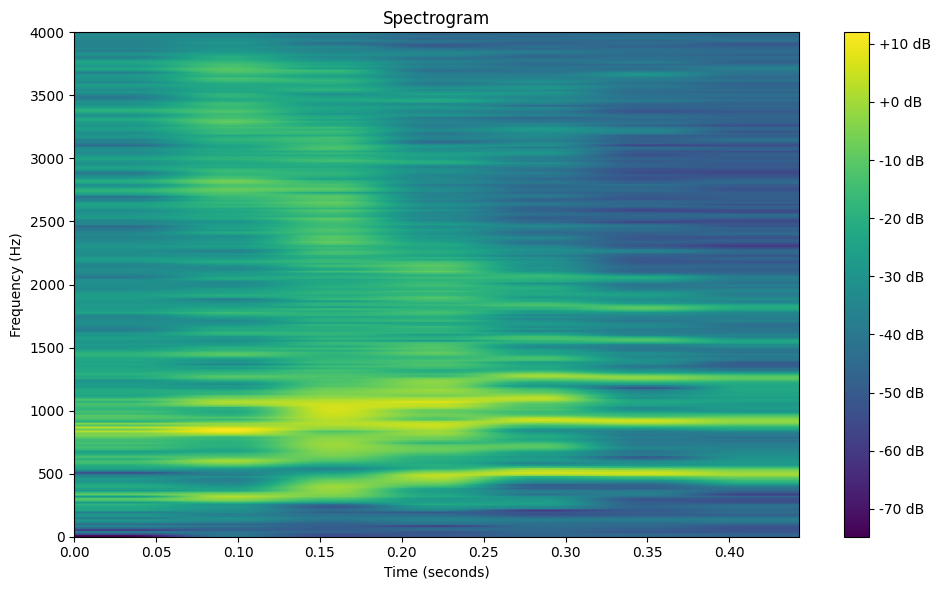

In [199]:
plot_audio(waveform)

## Dataloader

Let's build a Dataloader for getting all files

In [200]:

class SpokenDigitDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the wav files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = []
        self.labels = []
        
        # Get all wav files and their labels
        for file in sorted(os.listdir(root_dir)):
            if file.endswith('.wav'):
                # Parse filename to get label: {digitLabel}_{speakerName}_{index}.wav
                digit_label = int(file.split('_')[0])  # Extract the digit (0-9)
                
                self.file_paths.append(os.path.join(root_dir, file))
                self.labels.append(digit_label)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # Load the audio file
        waveform, sample_rate = torchaudio.load(self.file_paths[idx])
        
        # Get label
        label = self.labels[idx]
        
        # Create sample dictionary
        sample = {'waveform': waveform, 'sample_rate': sample_rate, 'label': label}
        
        # Apply transforms if any
        if self.transform:
            sample = self.transform(sample)
            
        return sample


In [201]:
class AudioAugmentation:
    def __init__(self, time_shift_pct=0.1, pitch_shift=2):
        self.time_shift_pct = time_shift_pct
        self.pitch_shift = pitch_shift
        
    def __call__(self, sample):
        waveform = sample['waveform']
        
        # Time shifting (randomly shift the audio left or right)
        if torch.rand(1).item() > 0.5:
            shift_amount = int(waveform.shape[1] * self.time_shift_pct)
            if torch.rand(1).item() > 0.5:
                # Shift right
                waveform = torch.cat([torch.zeros(1, shift_amount), waveform[:, :-shift_amount]], dim=1)
            else:
                # Shift left
                waveform = torch.cat([waveform[:, shift_amount:], torch.zeros(1, shift_amount)], dim=1)
                
        # Add small amount of Gaussian noise
        if torch.rand(1).item() > 0.5:
            noise = torch.randn_like(waveform) * 0.005
            waveform = waveform + noise
        
        sample['waveform'] = waveform
        return sample

In [202]:
# Example of transforms you might want to apply
class FixAudioLength:
    def __init__(self, max_length):
        self.max_length = max_length
        
    def __call__(self, sample):
        waveform = sample['waveform']
        current_length = waveform.shape[1]
        
        if current_length > self.max_length:
            # Truncate if longer than max_length
            sample['waveform'] = waveform[:, :self.max_length]
        elif current_length < self.max_length:
            # Pad with zeros if shorter
            padding = torch.zeros(waveform.shape[0], self.max_length - current_length)
            sample['waveform'] = torch.cat((waveform, padding), dim=1)
            
        return sample

In [203]:
class ImprovedMelSpectrogram:
    def __init__(self, sample_rate=8000, n_mels=128):
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=512,  # Smaller FFT for better time resolution
            win_length=400,  # Shorter window
            hop_length=160,  # Smaller hop for more time frames
            n_mels=n_mels,
            f_min=20,  # Focus on useful frequency range
            f_max=4000
        )
        # Add log-scaling to enhance features
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
        
    def __call__(self, sample):
        waveform = sample['waveform']
        melspec = self.melspec(waveform)
        # Convert to decibels, which is better for audio recognition
        melspec = self.amplitude_to_db(melspec)
        sample['melspec'] = melspec
        return sample

In [204]:
# Usage example
def get_train_eval_dataloaders(batch_size=32, train_ratio=0.8, num_workers=4):
    # Define the dataset path
    dataset_path = "/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings"
    
    # Define transforms
    # First, we'll analyze a few files to determine a good fixed length
    sample_rate = 8000  # Sample rate
    max_length_in_s = 0.5
    transforms = Compose([
        # AudioAugmentation(),  # Add augmentation first
        FixAudioLength(max_length=int(sample_rate * max_length_in_s)),
        ImprovedMelSpectrogram(sample_rate=sample_rate, n_mels=256)
    ])
    
    # Create full dataset
    full_dataset = SpokenDigitDataset(root_dir=dataset_path, transform=transforms)
    
    # Calculate sizes for training and evaluation sets
    dataset_size = len(full_dataset)
    train_size = int(train_ratio * dataset_size)
    eval_size = dataset_size - train_size
    
    # Split the dataset
    train_dataset, eval_dataset = random_split(full_dataset, [train_size, eval_size])
    
    # Create dataloaders
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    eval_dataloader = DataLoader(
        dataset=eval_dataset,
        batch_size=batch_size,
        shuffle=False,  # No need to shuffle evaluation data
        num_workers=num_workers
    )
    
    return train_dataloader, eval_dataloader

## Probing the dataloader

We can check the dataloader now.
Let's use batches of size 32.

In [205]:
train_loader, eval_loader = get_train_eval_dataloaders(batch_size=32, train_ratio=0.5)
    
# Print dataset info
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Evaluation samples: {len(eval_loader.dataset)}")

# Get a batch from each
for batch in train_loader:
    mels = batch['melspec']
    labels = batch['label']
    print(f"Training batch shape: {mels.shape}")
    print(f"Training labels: {labels}")
    break  # Just show the first batch
    
for batch in eval_loader:
    mels = batch['melspec']
    labels = batch['label']
    print(f"Evaluation batch shape: {mels.shape}")
    print(f"Evaluation labels: {labels}")
    break  # Just show the first batch

Training samples: 1500
Evaluation samples: 1500
Training batch shape: torch.Size([32, 1, 256, 26])
Training labels: tensor([7, 2, 5, 1, 3, 1, 1, 6, 8, 2, 7, 7, 7, 4, 1, 7, 9, 1, 3, 8, 7, 1, 9, 6,
        0, 0, 7, 2, 0, 3, 1, 9])
Evaluation batch shape: torch.Size([32, 1, 256, 26])
Evaluation labels: tensor([2, 3, 8, 3, 3, 7, 6, 2, 4, 0, 9, 0, 1, 1, 5, 2, 8, 0, 5, 0, 5, 2, 8, 2,
        8, 9, 2, 4, 2, 5, 1, 6])


We have 3000 samples.
One batch has the size torch.Size([32, 1, 8000]):

- First dimension (32): Your batch size
- Second dimension (1): Number of audio channels
- 3rd dimension (265): Number of frequency steps
- 4th dimension(16): Number of time frames of mel spectogram

## Training a network


Let's write a simple conv net for classifying the dataset:

In [206]:
class ImprovedAudioCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedAudioCNN, self).__init__()
        # Input: [batch, 1, 256, 16]
        
        # Deeper network with residual connections
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # First block with residual connection
        residual = x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x + residual  # Residual connection
        x = self.pool1(x)
        
        # Second block with residual connection
        residual = x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x + residual  # Residual connection
        x = self.pool2(x)
        
        # Third block with residual connection
        residual = x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = x + residual  # Residual connection
        x = self.pool3(x)
        
        # Global average pooling
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        
        return x

In [207]:
# Improved training with learning rate scheduling
def train_with_lr_scheduler(model, train_loader, eval_loader, criterion, optimizer, device, epochs=20):
    # Create a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    # Initialize metric tracking
    train_losses = []
    train_accuracies = []
    eval_losses = []
    eval_accuracies = []
    
    best_eval_acc = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in train_loader:
            mels = batch['melspec'].to(device)
            labels = batch['label'].to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(mels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate average training metrics for this epoch
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        # Evaluation phase
        model.eval()
        eval_running_loss = 0.0
        eval_correct = 0
        eval_total = 0
        
        with torch.no_grad():
            for batch in eval_loader:
                mels = batch['melspec'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(mels)
                loss = criterion(outputs, labels)
                
                eval_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                eval_total += labels.size(0)
                eval_correct += (predicted == labels).sum().item()
        
        # Calculate average evaluation metrics for this epoch
        epoch_eval_loss = eval_running_loss / len(eval_loader)
        epoch_eval_acc = 100 * eval_correct / eval_total
        eval_losses.append(epoch_eval_loss)
        eval_accuracies.append(epoch_eval_acc)

        # Step the scheduler based on evaluation loss
        scheduler.step(epoch_eval_loss)
        
        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Eval Loss: {epoch_eval_loss:.4f}, Eval Acc: {epoch_eval_acc:.2f}%')
        print('-' * 60)
    
    print('Finished Training')
    
    # Return metrics for plotting
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'eval_losses': eval_losses,
        'eval_accuracies': eval_accuracies
    }

In [208]:
def plot_training_metrics(metrics):
    """
    Plot the training and evaluation metrics.
    
    Args:
        metrics (dict): Dictionary containing lists of metrics
    """
    epochs = range(1, len(metrics['train_losses']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_losses'], 'b-', label='Training Loss')
    plt.plot(epochs, metrics['eval_losses'], 'r-', label='Evaluation Loss')
    plt.title('Training and Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_accuracies'], 'b-', label='Training Accuracy')
    plt.plot(epochs, metrics['eval_accuracies'], 'r-', label='Evaluation Accuracy')
    plt.title('Training and Evaluation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

In [209]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in dataloader:
            mels = batch['melspec'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(mels)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Using device: cuda
Epoch 1/64
Train Loss: 2.2690, Train Acc: 14.13%
Eval Loss: 2.2447, Eval Acc: 18.13%
------------------------------------------------------------
Epoch 2/64
Train Loss: 2.1110, Train Acc: 24.87%
Eval Loss: 2.1085, Eval Acc: 28.53%
------------------------------------------------------------
Epoch 3/64
Train Loss: 1.9477, Train Acc: 31.47%
Eval Loss: 1.9770, Eval Acc: 28.93%
------------------------------------------------------------
Epoch 4/64
Train Loss: 1.7464, Train Acc: 41.80%
Eval Loss: 1.7522, Eval Acc: 40.40%
------------------------------------------------------------
Epoch 5/64
Train Loss: 1.5463, Train Acc: 49.93%
Eval Loss: 1.6877, Eval Acc: 39.33%
------------------------------------------------------------
Epoch 6/64
Train Loss: 1.3502, Train Acc: 57.47%
Eval Loss: 1.4384, Eval Acc: 51.13%
------------------------------------------------------------
Epoch 7/64
Train Loss: 1.1526, Train Acc: 64.67%
Eval Loss: 1.2344, Eval Acc: 60.87%
--------------------

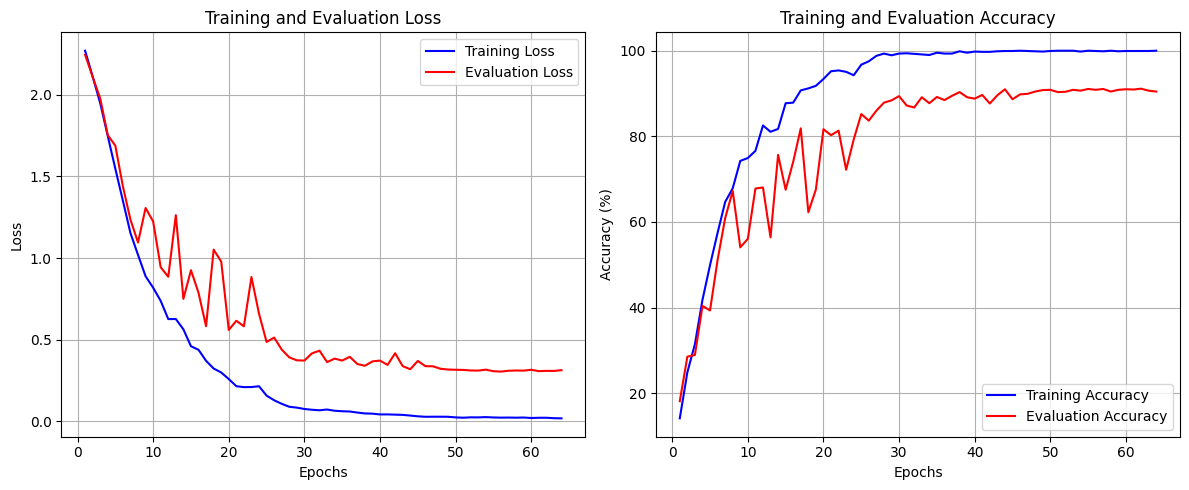

In [231]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create dataloaders
train_loader, eval_loader = get_train_eval_dataloaders(batch_size=128, train_ratio=0.5)

# Create model
model = ImprovedAudioCNN(num_classes=10).to(device)  # 10 classes for digits 0-9

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Modify optimizer to include weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.00025, weight_decay=1e-5)

# Train for more epochs
metrics = train_with_lr_scheduler(model, train_loader, eval_loader, criterion, optimizer, device, epochs=64)

# Plot the metrics
plot_training_metrics(metrics)

# Save the model
torch.save(model.state_dict(), "audio_cnn_model.pth")

In [234]:
def predict_and_play_example(model, eval_loader, device):
    model.eval()
    
    # Get a single batch
    batch = next(iter(eval_loader))
    
    # Get the original waveform if available, otherwise use the raw file path
    waveform = batch.get('waveform', None)
    if waveform is None and 'file_path' in batch:
        waveform, sample_rate = torchaudio.load(batch['file_path'][0])
    else:
        waveform = batch['waveform'][0]
        sample_rate = batch['sample_rate'][0] if 'sample_rate' in batch else 8000
    
    # Select just the first example for the mel spectrogram
    mel = batch['melspec'][0:1].to(device)
    true_label = batch['label'][0].item()

    audio_data = waveform[0].cpu().numpy().astype(np.float32)
    
    
    # Make prediction
    with torch.no_grad():
        outputs = model(mel)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    # Print results
    print(f"True digit: {true_label}")
    print(f"Predicted digit: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")

    
    plt.figure(figsize=(12, 6))
    
    # Plot waveform
    plt.subplot(2, 1, 1)
    plt.plot(audio_data)
    plt.title(f"Waveform - True: {true_label}, Predicted: {predicted_class}")
    plt.ylabel("Amplitude")
    
    # Plot mel spectrogram
    plt.subplot(2, 1, 2)
    plt.imshow(mel[0][0].cpu().numpy(), aspect='auto', origin='lower')
    plt.title("Mel Spectrogram")
    plt.ylabel("Mel Frequency")
    plt.xlabel("Time")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    # Play the audio
    print("Audio playback:")

    display(Audio(audio_data, rate=sample_rate.item()))
    
    return true_label, predicted_class, confidence, waveform


True digit: 4
Predicted digit: 4
Confidence: 0.9962


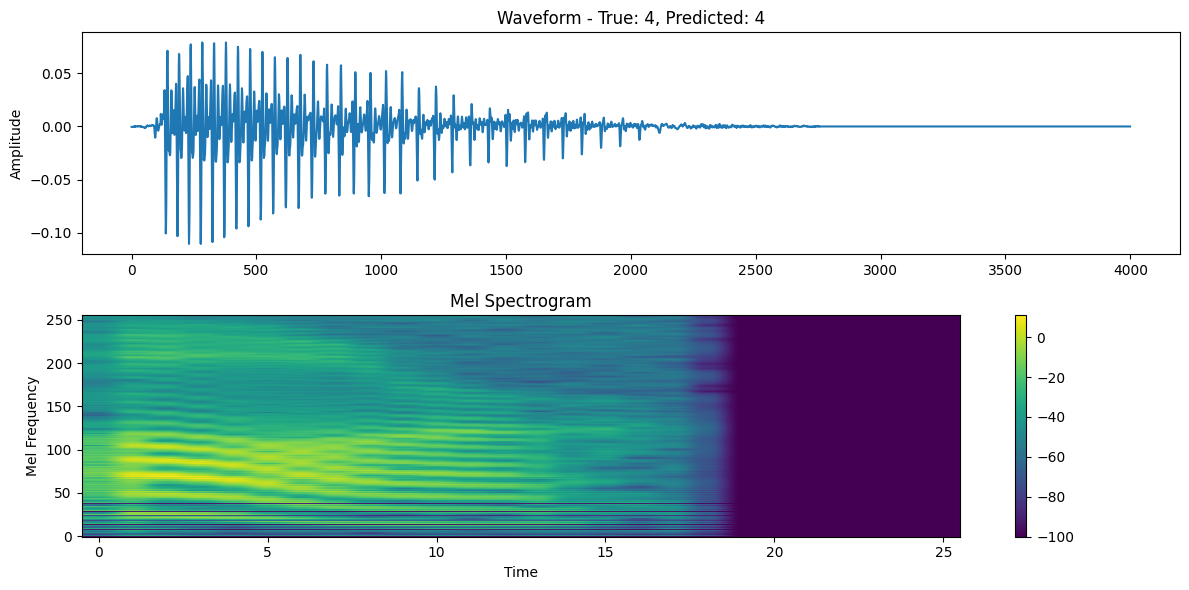

Audio playback:


In [235]:
true_label, pred_label, confidence, waveform = predict_and_play_example(model, eval_loader, device)